### PH464/564: Scientific Computing II
***J.S. Hazboun***
#### Katelyn Ebert
___

# Lecture/Homework 03
### Due: Friday, October 18th at 11:59pm Pacific
---

# Modeling w/ NumPyro

1. Use `NumPyro` to define a model containing a single random variable that follows a [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution) [distribution](https://num.pyro.ai/en/stable/distributions.html#gamma) with shape parameters $\alpha=5$, $\beta=0.1$.  First draw samples directly from the distribution and plot the histogram and/or KDE.

1. Using the samples you've drawn, compute the mean and variance of the random variable. Modify the shape parameters individually to see how each of them affect the mean and variance of the distribution.

1. The Gamma distribution doesn't have support for negative values, making it a useful prior distribution for parameters that must be positive. Use `NumPyro` to conduct an MCMC sampling of our linear regression model with outliers from class, but replace the half-normal priors for standard deviation parameters with sensible gamma distributions (i.e., not dramatically different in scale from the half-normal distributions previously used). Does the change in prior distribution meaningfully change the posterior distributions?

## Problem 1
1. Form Gamma Distribution, plot histogram of draws from gamma distribution and KDE

In [30]:
# All the imports!
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
import math
import seaborn as sns

In [31]:
## Define a Gamma Distribution with alpha = 5, beta = 0.1
alpha = 5
beta = 0.1
x = np.linspace(0,200,1000)
gamma = scipy.stats.gamma.pdf(x,a =alpha, loc=0, scale = 1 / beta)

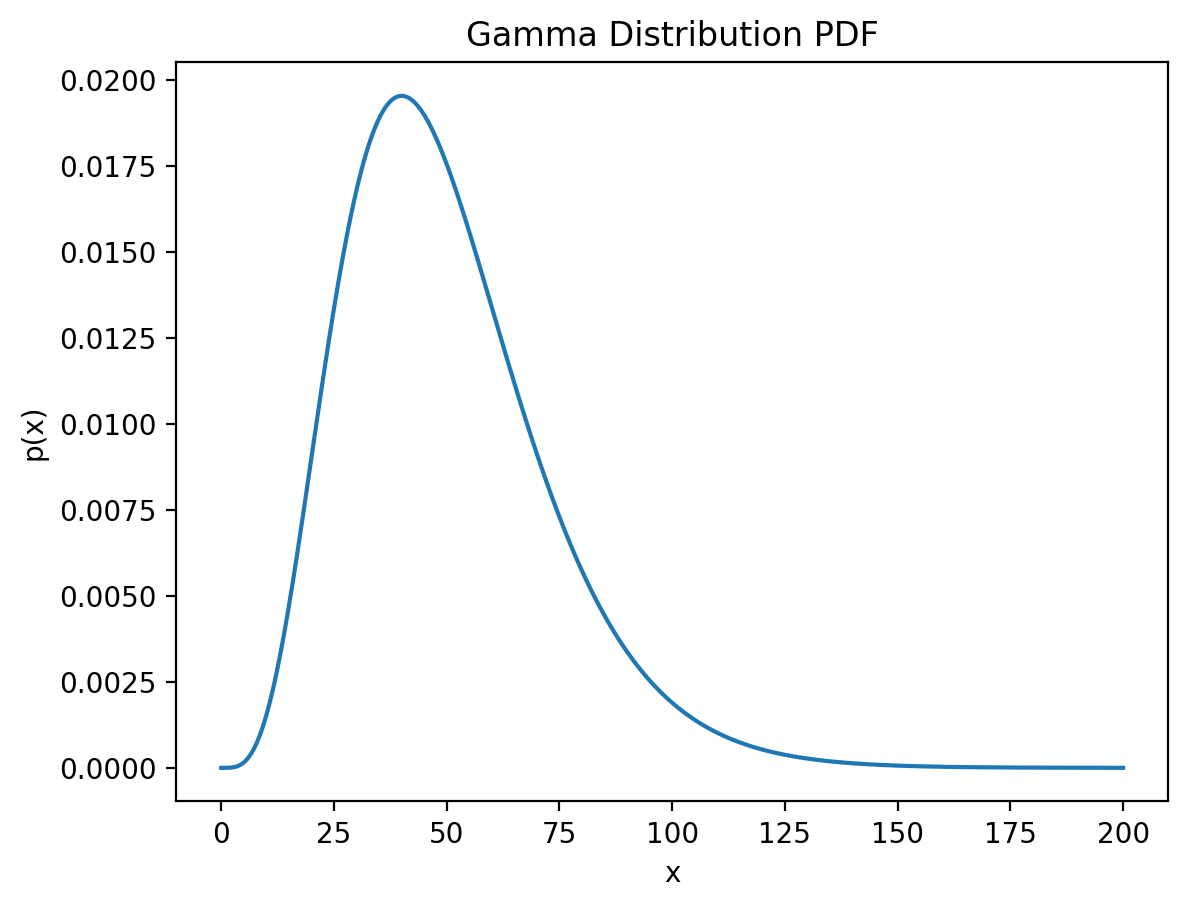

In [32]:
plt.plot(x,gamma)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.title("Gamma Distribution PDF")
plt.show()

In [33]:
draws = scipy.stats.gamma.rvs(a=alpha,loc=0,scale=1/beta,size=1000)
print(len(draws))

1000


Text(0.5, 1.0, 'Histogram of Draws from Gamma Distirubtion')

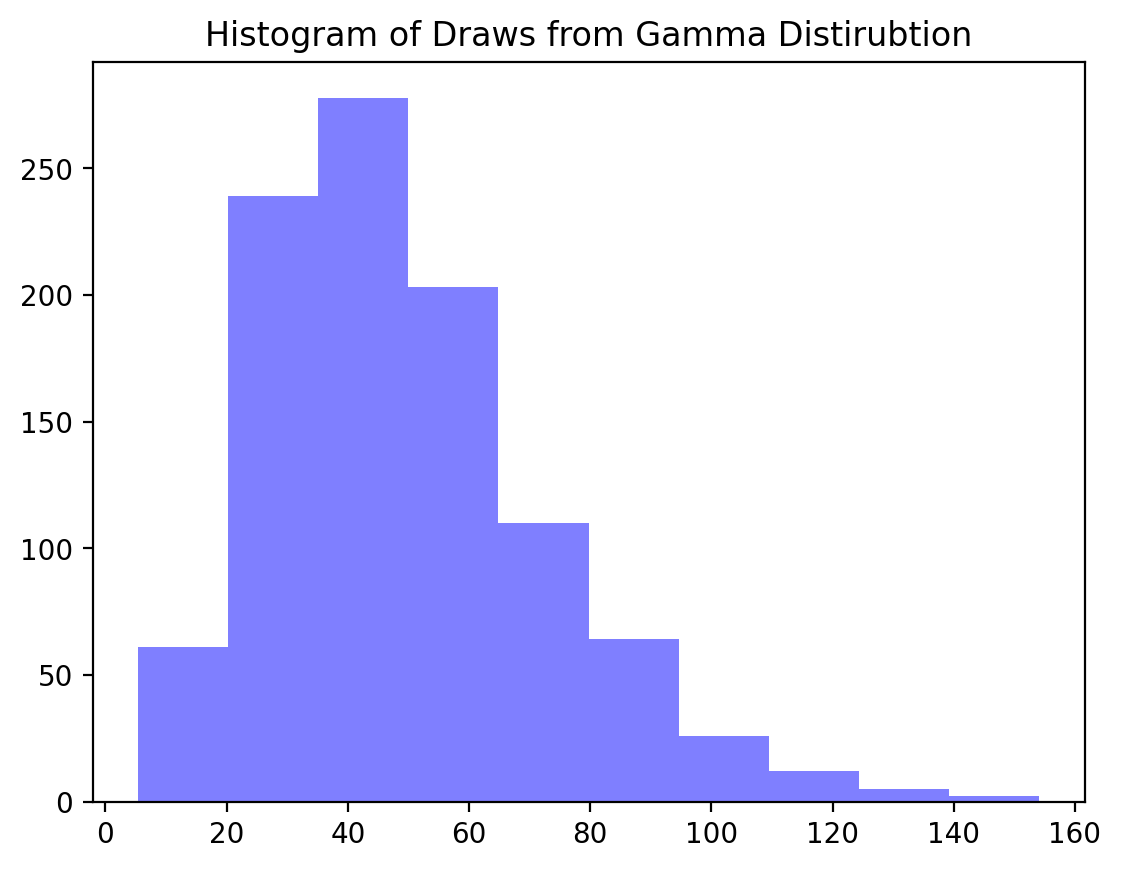

In [34]:
plt.hist(draws, alpha=0.5, color='blue')
plt.title('Histogram of Draws from Gamma Distirubtion')

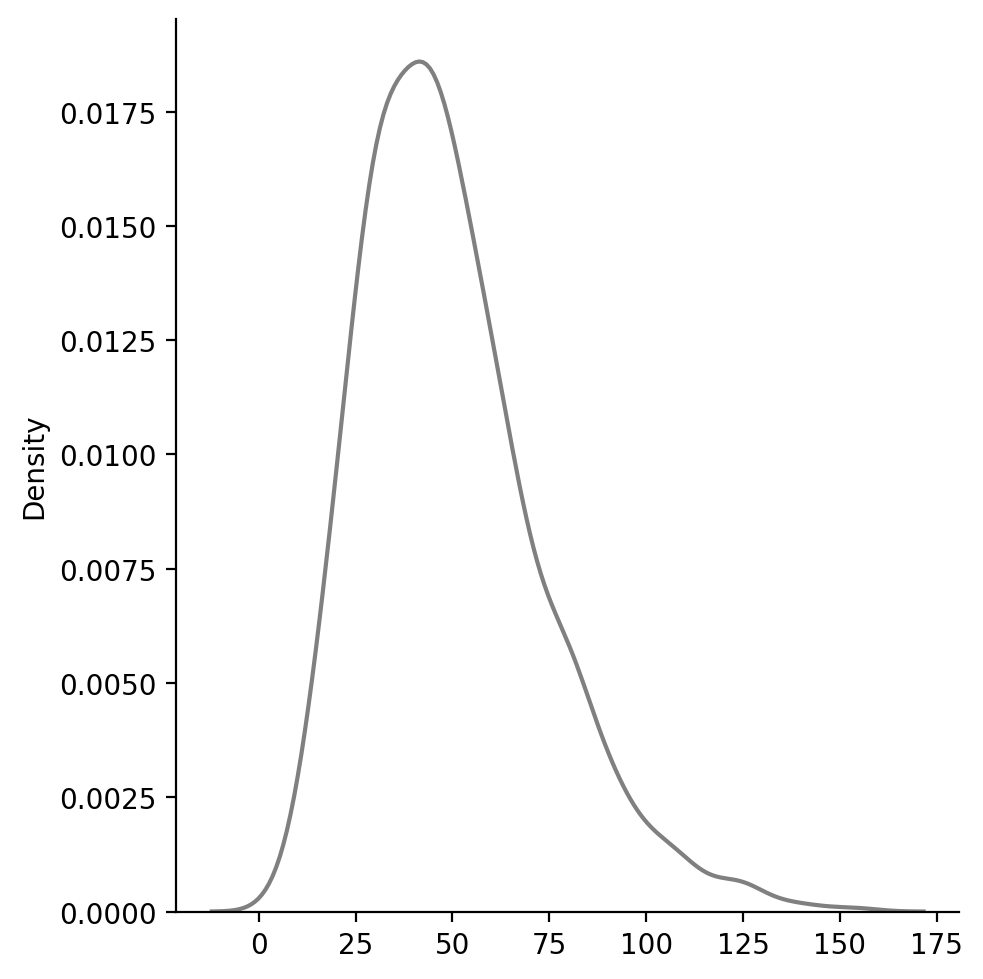

In [35]:
sns.displot(draws, kind='kde', color = 'grey');

2. Find the mean and variance.
See how the alpha and beta parameters affect the mean and variance

In [36]:
mean= np.mean(draws)
var = np.var(draws)
print('With alpha = ', alpha, 'and beta =', beta, 'the mean is', round(mean,1),'and the variance is', round(var,1))

With alpha =  5 and beta = 0.1 the mean is 49.6 and the variance is 535.4


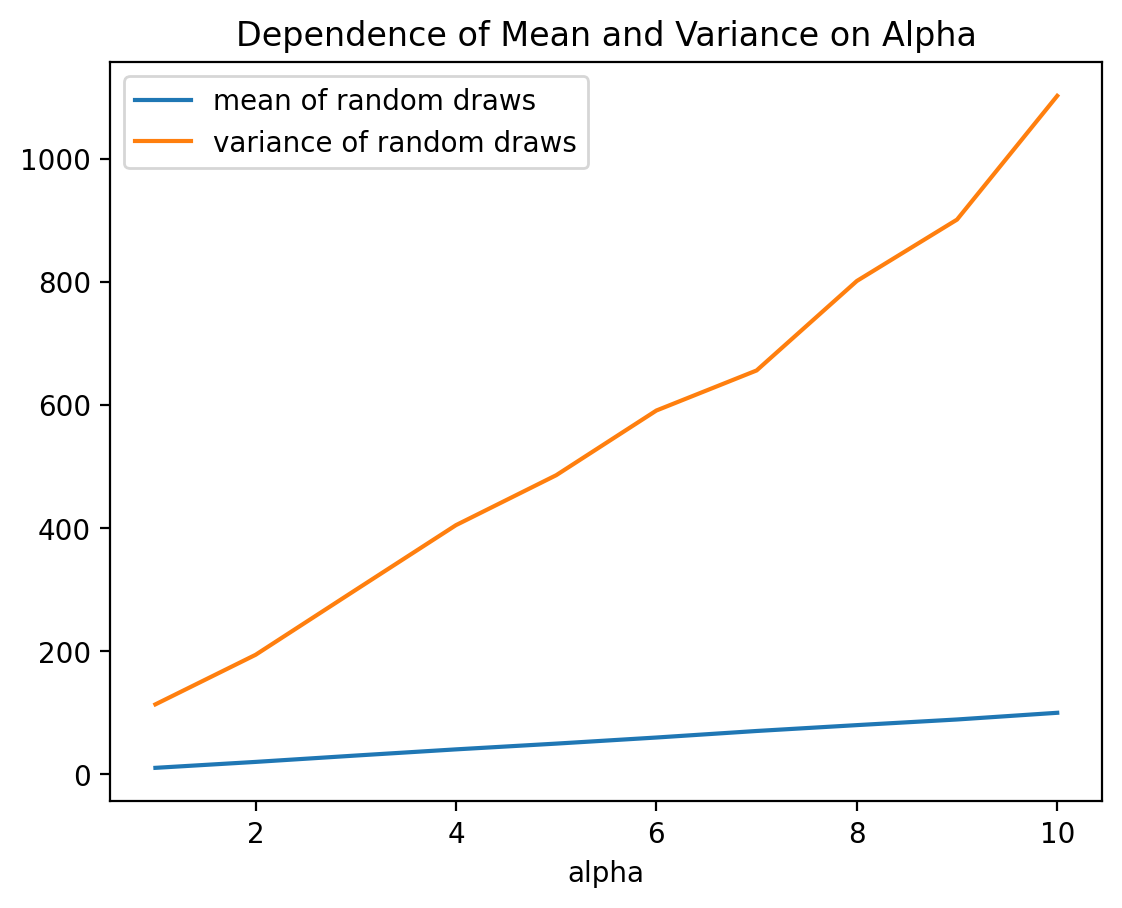

In [37]:
beta = 0.1 # set beta as a specific value
alpha = np.linspace(1,10,10) # vary alpha across reasonable parameter space
mean = []
var = []
for i in alpha:   
    dist = scipy.stats.gamma.rvs(a=i,loc=0,scale=1/beta,size=1000)   # make a gamma distribution for each alpha, gamma pair
    mean.append(np.mean(dist))   # append the mean and variance
    var.append(np.var(dist))
plt.plot(alpha,mean,label='mean of random draws')   # plot the results against the attempted alphas
plt.plot(alpha,var,label='variance of random draws')
plt.xlabel('alpha')
plt.title('Dependence of Mean and Variance on Alpha')
plt.legend()
plt.show()


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


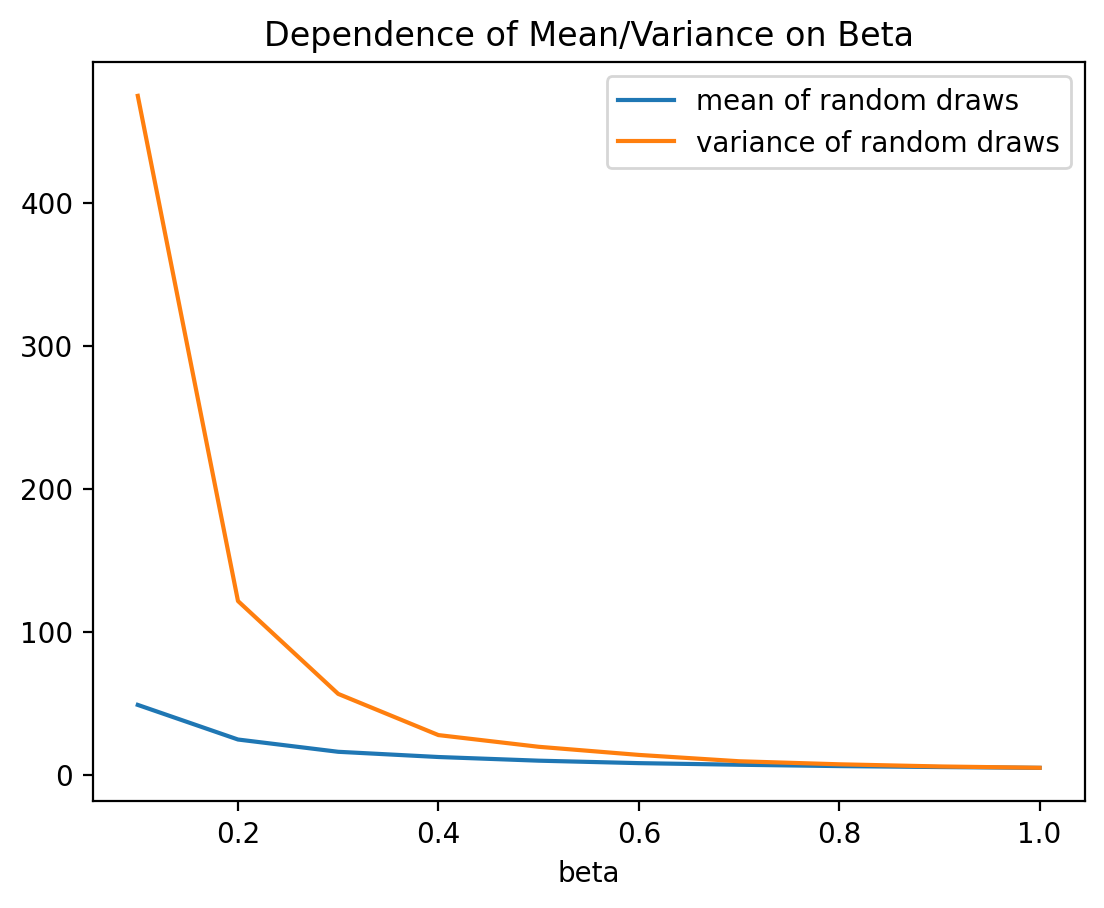

In [38]:
alpha = 5   # repeat, holding alpha constant as our original value
beta = np.linspace(0.1,1,10)    # beta seems to be a smaller value
print(beta)
mean = []
var = []
for i in beta:
    dist = scipy.stats.gamma.rvs(a=alpha,loc=0,scale=1/i,size=1000)  # make a gamma distribution for each alpha, gamma pair
    mean.append(np.mean(dist))
    var.append(np.var(dist))
plt.plot(beta,mean,label='mean of random draws')
plt.plot(beta,var,label='variance of random draws')
plt.xlabel('beta')
plt.title('Dependence of Mean/Variance on Beta')
plt.legend()
plt.show()

So the variance spikes sharply as beta decreases below 0.2, and increases semi-linearly with alpha.
Average decreases slightly with increasing beta, and increases linearly with alpha.

3. Repeat Intro to NumPyro Linear Regression, but with (similar shaped) Gamma Distribution for prior and compare posteriors

In [43]:
## numpyro and jax imports!

from numpy import genfromtxt

import jax
from jax import random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro import infer
numpyro.set_host_device_count(2) # let's use 2 cores!

import matplotlib.pyplot as plt
import arviz as az

In [44]:
# The data to be modelled...
data = genfromtxt('../data/data_yerr.dat', names=True, comments='#', delimiter='&')
data

array([( 1., 201., 592., 61.), ( 2., 244., 401., 25.),
       ( 3.,  47., 583., 38.), ( 4., 287., 402., 15.),
       ( 5., 203., 495., 21.), ( 6.,  58., 173., 15.),
       ( 7., 210., 479., 27.), ( 8., 202., 504., 14.),
       ( 9., 198., 510., 30.), (10., 158., 416., 16.),
       (11., 165., 393., 14.), (12., 201., 442., 25.),
       (13., 157., 317., 52.), (14., 131., 311., 16.),
       (15., 166., 400., 34.), (16., 160., 337., 31.),
       (17., 186., 423., 42.), (18., 125., 334., 26.),
       (19., 218., 533., 16.), (20., 146., 344., 22.)],
      dtype=[('index', '<f8'), ('x', '<f8'), ('y', '<f8'), ('sigm_y', '<f8')])

In [45]:
def linear_model_w_outliers(x=None, y=None, σ_y=None):
    # First let's construct our foreground (i.e., linear) model
    m = numpyro.sample('m', dist.Uniform(0, 5))
    b = numpyro.sample('b', dist.Uniform(0, 500))
    μ_fg = m * x + b
    dist_fg = dist.Normal(μ_fg, σ_y)

    # Now lets define a model for the background (i.e., outliers)
    μ_bg = numpyro.sample('μ_bg', dist.Normal(loc=400, scale=500))
    σ_bg = numpyro.sample('σ_bg', dist.HalfNormal(scale=500))
    dist_bg = dist.Normal(μ_bg, jnp.sqrt(σ_bg**2 + σ_y**2))

    # We're going to assign each observation probabilistically to fg or bg using Categorical parameters
    P_fg = numpyro.sample('P_fg', dist.Uniform(0, 1)) # Prob an observation will be in the foreground

    # Define the foreground/background parameters, with equal probability between categories
    mixing_dist = dist.Categorical(probs=jnp.array([P_fg, 1 - P_fg]))
    mixture = dist.MixtureGeneral(mixing_dist, [dist_fg, dist_bg])

    # Likelihood
    with numpyro.plate("data", len(x)):
        y_ = numpyro.sample("obs", mixture, obs=y)

        # Until here, where we can track the membership probability of each sample
        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            "log_p_fg", log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True)
        )

In [46]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(linear_model_w_outliers)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         x=data['x'],
         y=data['y'],
         σ_y=data['sigm_y'])
mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      P_fg      0.72      0.12      0.73      0.52      0.91   5346.41      1.00
         b     34.57     17.27     33.67      4.37     60.13   3529.69      1.00
         m      2.24      0.11      2.25      2.07      2.41   3498.89      1.00
      μ_bg    450.70     78.35    448.02    336.84    566.84   2566.63      1.00
      σ_bg    134.06     92.70    108.07     33.11    249.12   2944.49      1.00

Number of divergences: 0


{'P_fg': Array([0.61233604, 0.7830283 , 0.7376472 , ..., 0.621265  , 0.56971484,
       0.9070664 ], dtype=float32), 'b': Array([46.90615 , 30.51398 , 39.905476, ..., 10.89452 , 18.23363 ,
       32.926098], dtype=float32), 'log_p_fg': Array([[[-4.9104977e-01, -9.4670725e-01],
        [-2.3039810e+01,  0.0000000e+00],
        [-6.2716125e+01,  0.0000000e+00],
        ...,
        [-1.1166906e-01, -2.2475319e+00],
        [-6.9203377e-02, -2.7051048e+00],
        [-1.3168526e-01, -2.0924606e+00]],

       [[-4.8446989e-01, -9.5717478e-01],
        [-2.1170502e+01,  0.0000000e+00],
        [-6.6739487e+01,  0.0000000e+00],
        ...,
        [-2.1356106e-02, -3.8570776e+00],
        [-5.4116726e-02, -2.9435515e+00],
        [-1.6264915e-02, -4.1268692e+00]],

       [[-5.4709291e-01, -8.6424255e-01],
        [-1.9877201e+01,  0.0000000e+00],
        [-6.4827545e+01,  0.0000000e+00],
        ...,
        [-4.5640469e-02, -3.1096964e+00],
        [-8.2529068e-02, -2.5355873e+00],
       

/home/snazzgul/micromamba/envs/scicomp/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


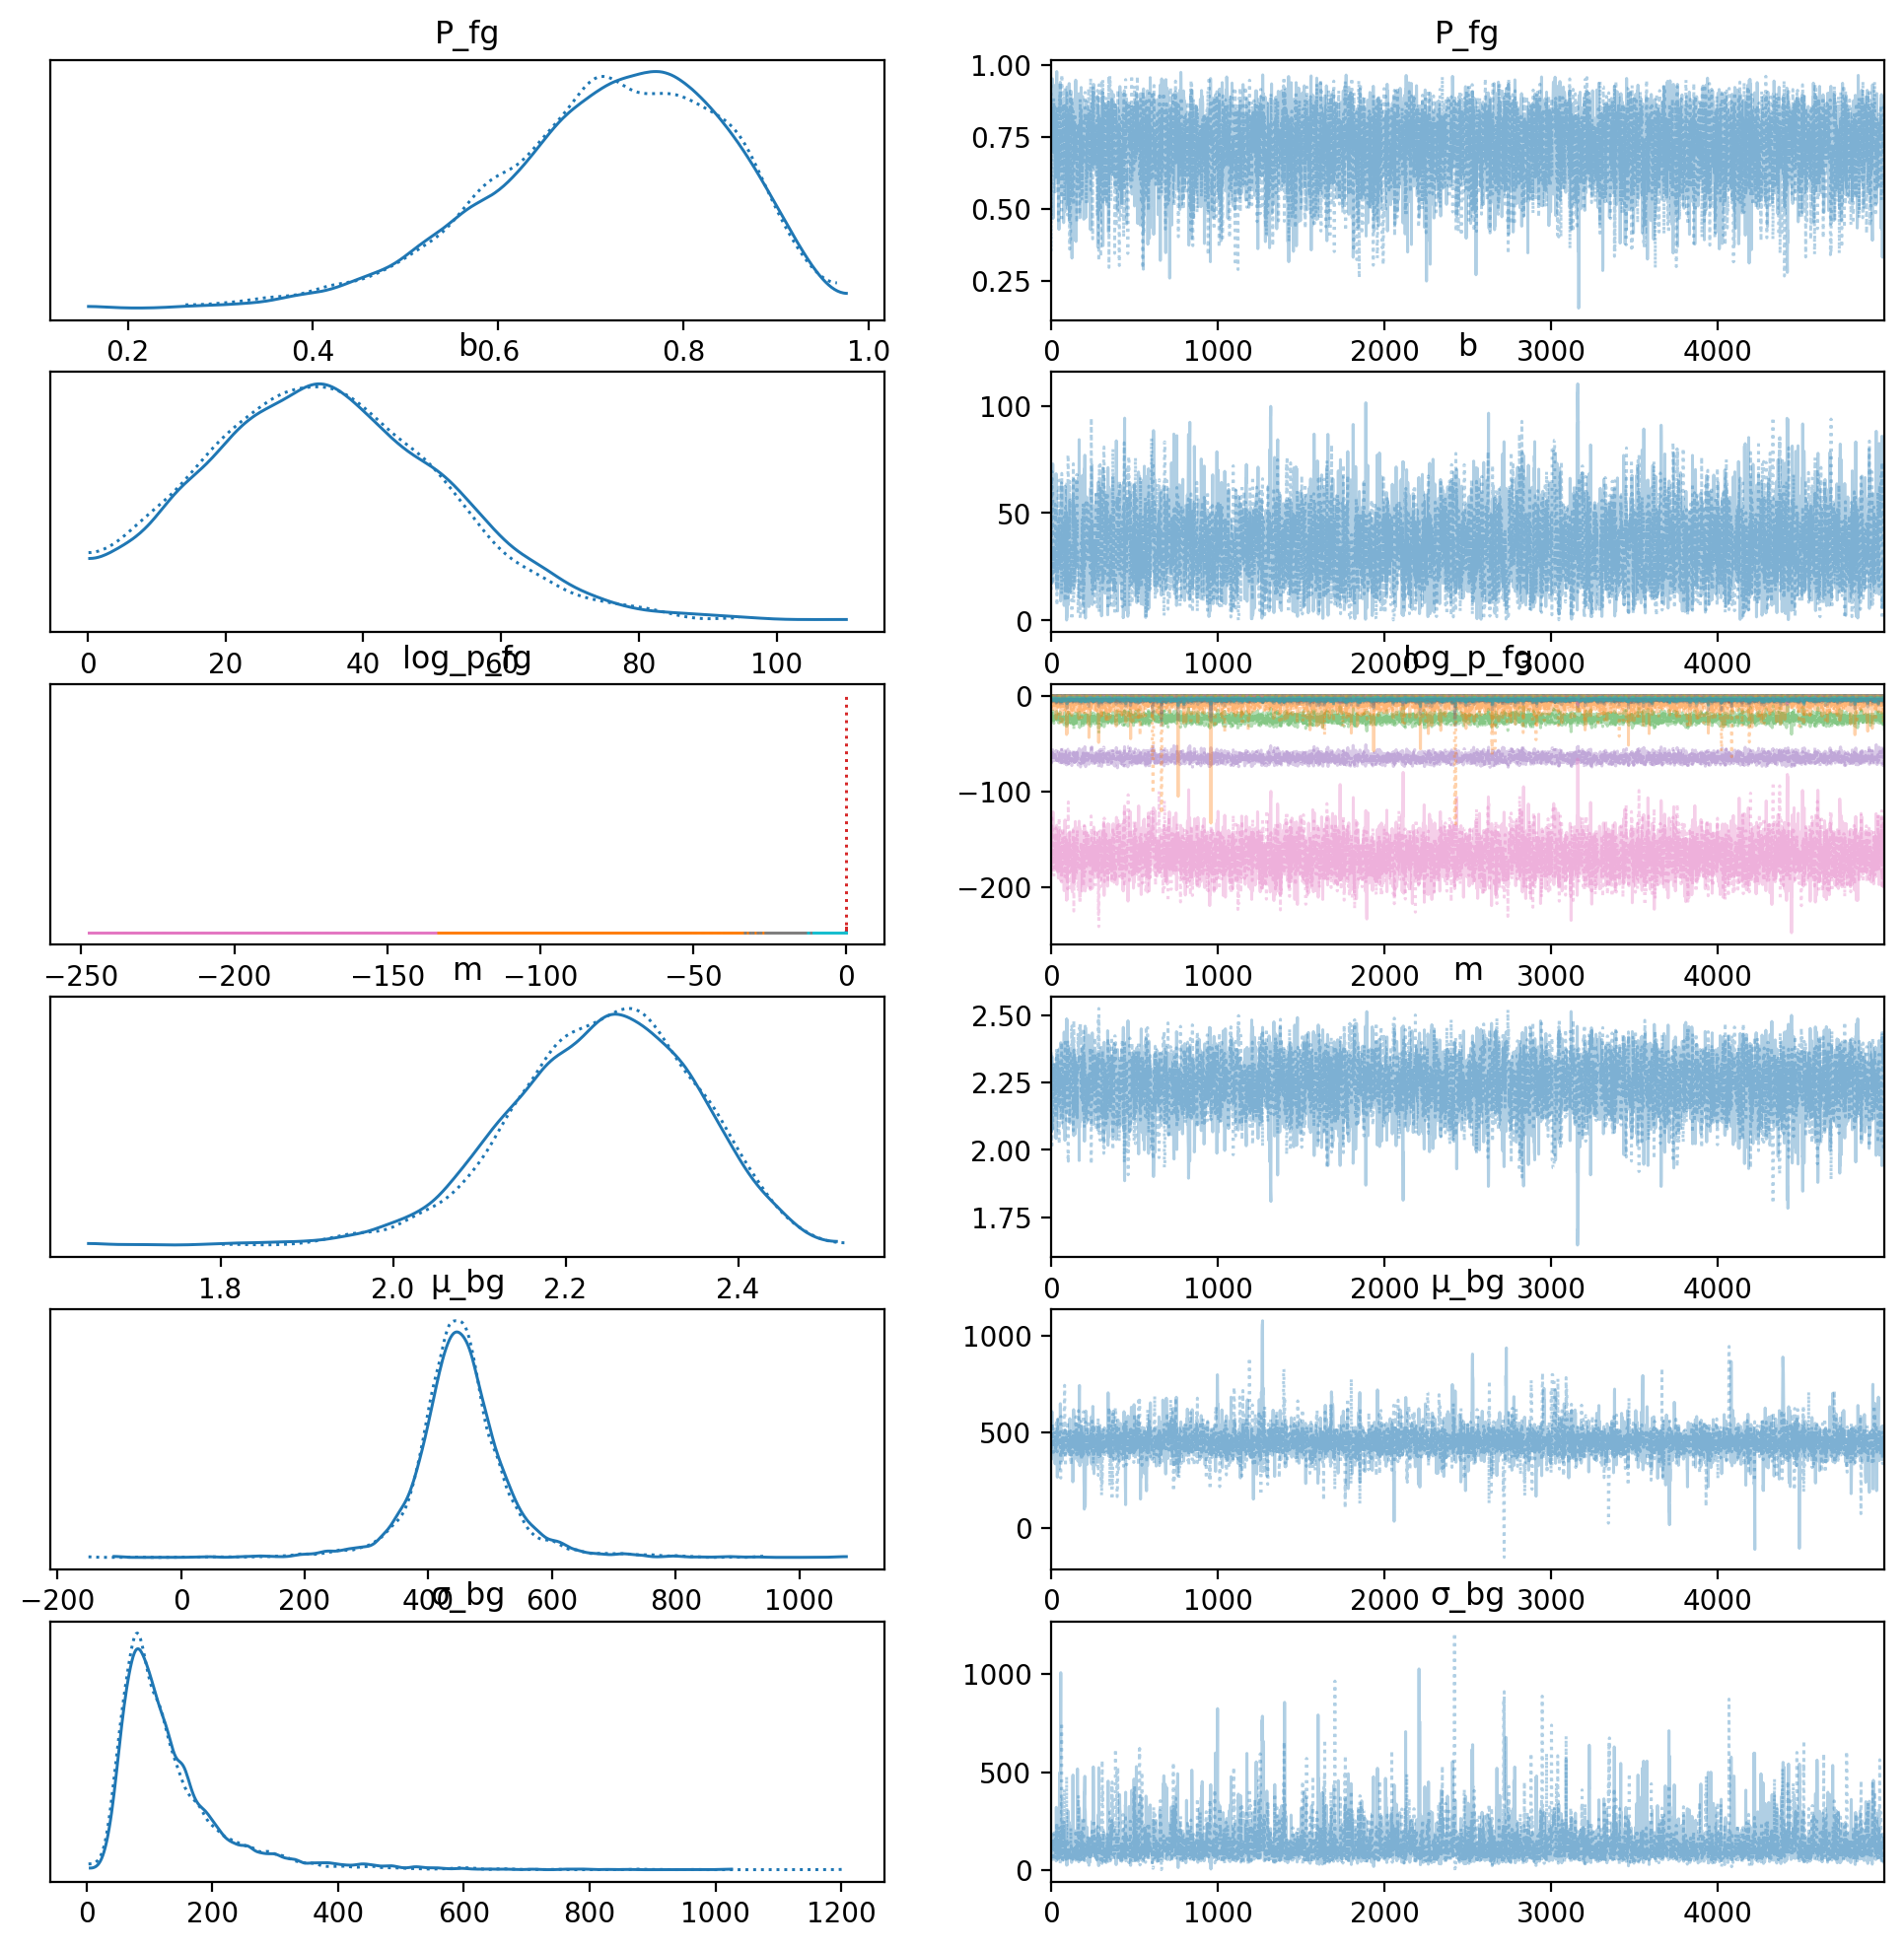

In [47]:
samples = mcmc.get_samples()
print(samples)
print(samples['b'].shape)
az.plot_trace(mcmc);

In [ ]:
print(dist.HalfNormal(scale=10).sample(key=rng_key, sample_shape=(10,)))

[26.105583    0.33852828 10.863333   14.802988    4.8895674  10.62516
  5.4174833   0.170228    2.722685    3.0522447 ]


(array([ 32., 163., 242., 226., 152., 103.,  47.,  22.,   9.,   4.]),
 array([  3.77757426,  17.06111834,  30.34466243,  43.62820651,
         56.91175059,  70.19529468,  83.47883876,  96.76238285,
        110.04592693, 123.32947101, 136.6130151 ]),
 <BarContainer object of 10 artists>)

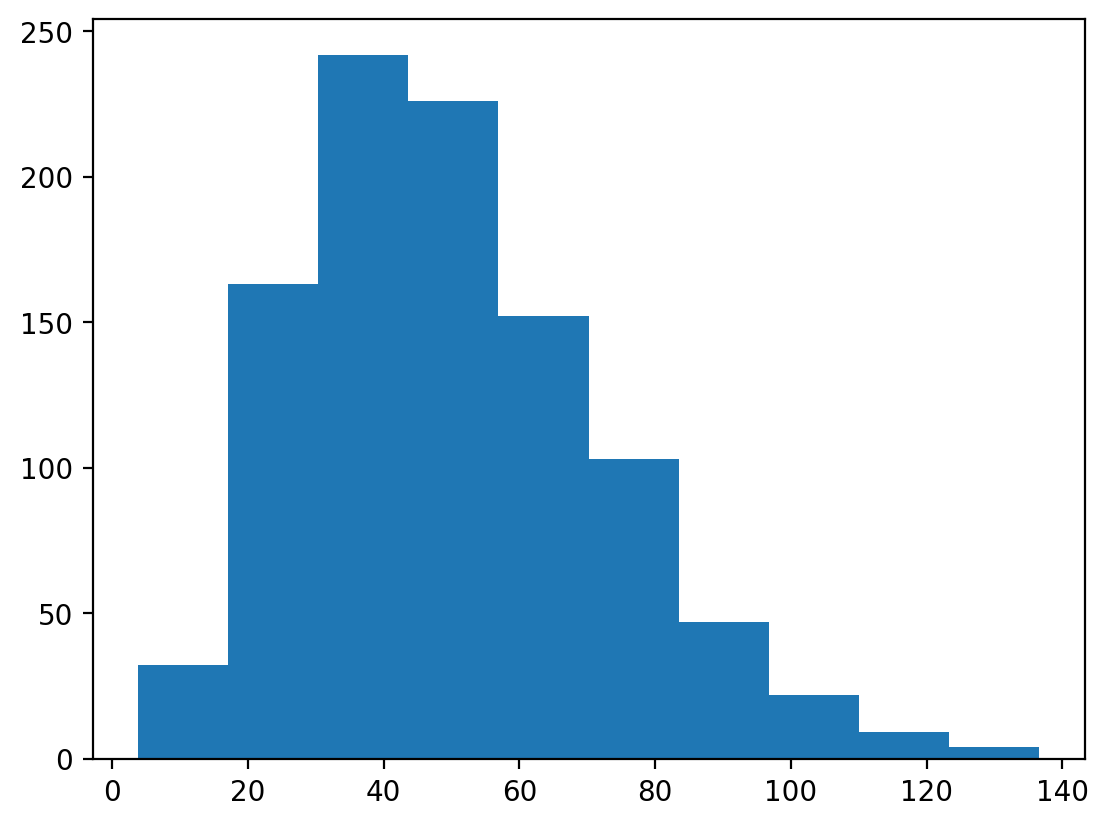

In [48]:
alpha=5 # shape, with our original parameters
beta=0.1 # rate
draws = scipy.stats.gamma.rvs(a=alpha,loc=0,scale=1/beta,size=1000)
plt.hist(draws)

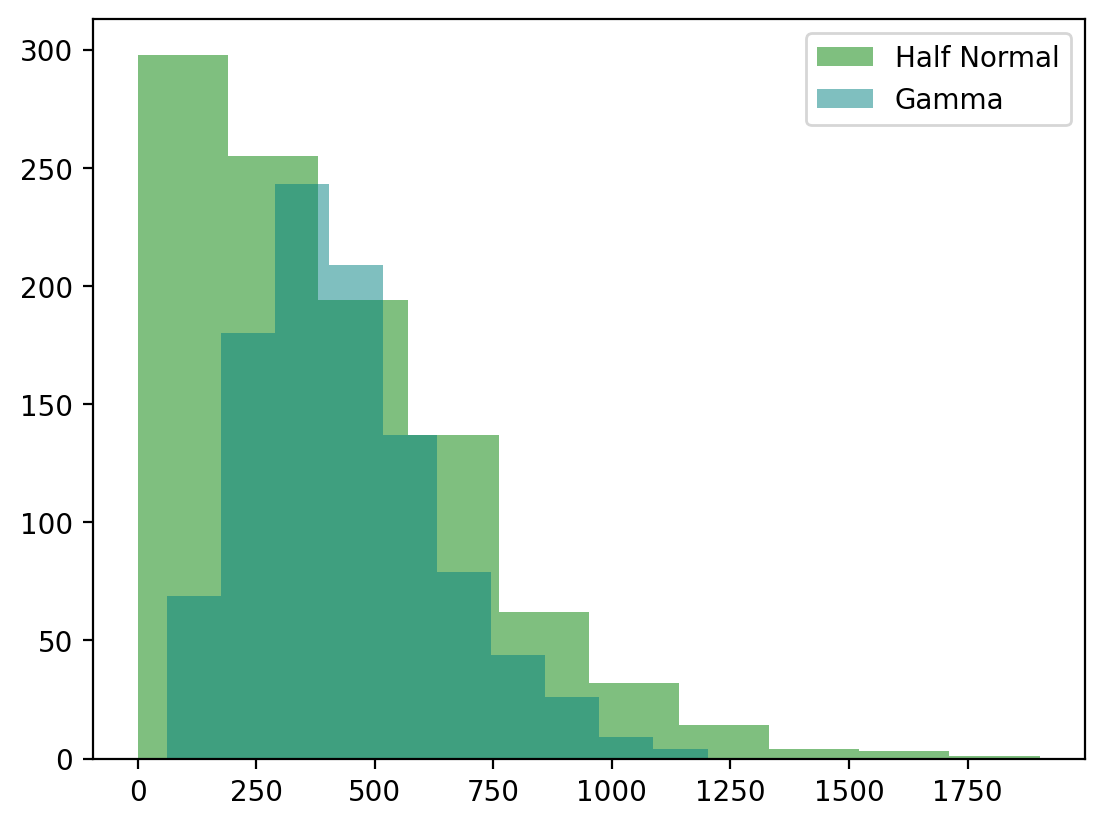

In [89]:
## To make sure our gamma distribution is close enough to our original distribution, let's plot a histogram of each
plt.hist(dist.HalfNormal(scale=500).sample(key=rng_key, sample_shape=(1000,)), color = 'g', label = 'Half Normal', alpha=0.5)

alpha=4.5 # shape, chosen after messing around with the histogram outputs til they match well
beta=0.01 # rate
samples = dist.Gamma(concentration=alpha, rate=beta).sample(key=rng_key, sample_shape=(1000,))
plt.hist(samples, color = 'teal', label = 'Gamma', alpha =0.5)
plt.legend()
plt.show()

This looks like a good match! It's shifted a bit from our Gamma at the start, but hopefully that's okay. Let's run it and see if our MCMC yields the same posteriors!

In [64]:
def linear_model_w_outliers(x=None, y=None, σ_y=None):
    # First let's construct our foreground (i.e., linear) model
    m = numpyro.sample('m', dist.Uniform(0, 5))
    b = numpyro.sample('b', dist.Uniform(0, 500))
    μ_fg = m * x + b
    dist_fg = dist.Normal(μ_fg, σ_y)

    # Now lets define a model for the background (i.e., outliers)
    μ_bg = numpyro.sample('μ_bg', dist.Normal(loc=400, scale=500))
    σ_bg = numpyro.sample('σ_bg', dist.Gamma(concentration=alpha, rate=beta))  ### HERE is the only change
    dist_bg = dist.Normal(μ_bg, jnp.sqrt(σ_bg**2 + σ_y**2))

    # We're going to assign each observation probabilistically to fg or bg using Categorical parameters
    P_fg = numpyro.sample('P_fg', dist.Uniform(0, 1)) # Prob an observation will be in the foreground

    # Define the foreground/background parameters, with equal probability between categories
    mixing_dist = dist.Categorical(probs=jnp.array([P_fg, 1 - P_fg]))
    mixture = dist.MixtureGeneral(mixing_dist, [dist_fg, dist_bg])

    # Likelihood
    with numpyro.plate("data", len(x)):
        y_ = numpyro.sample("obs", mixture, obs=y)

        # Until here, where we can track the membership probability of each sample
        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            "log_p_fg", log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True))

In [65]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(linear_model_w_outliers)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         x=data['x'],
         y=data['y'],
         σ_y=data['sigm_y'])
mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      P_fg      0.75      0.11      0.76      0.58      0.94   5458.57      1.00
         b     34.43     17.06     33.93      4.72     60.39   3075.92      1.00
         m      2.24      0.10      2.25      2.09      2.43   3001.65      1.00
      μ_bg    447.70    130.08    448.86    252.77    656.24   2016.80      1.00
      σ_bg    233.80    130.01    202.33     57.44    413.99   2973.54      1.00

Number of divergences: 0


{'P_fg': Array([0.8623275 , 0.7022689 , 0.68505305, ..., 0.48615396, 0.7565801 ,
       0.897927  ], dtype=float32), 'b': Array([21.584024, 46.229145, 53.160378, ..., 35.69183 , 56.80031 ,
       25.89259 ], dtype=float32), 'log_p_fg': Array([[[-1.4778519e-01, -1.9849787e+00],
        [-2.4527256e+01,  0.0000000e+00],
        [-6.7129616e+01,  0.0000000e+00],
        ...,
        [-3.2806396e-02, -3.4334917e+00],
        [-1.5498638e-02, -4.1747484e+00],
        [-2.7413368e-02, -3.6104069e+00]],

       [[-1.7187405e-01, -1.8456988e+00],
        [-2.4786001e+01,  0.0000000e+00],
        [-6.1346069e+01,  0.0000000e+00],
        ...,
        [-7.9376698e-02, -2.5729785e+00],
        [-2.0835876e-02, -3.8814816e+00],
        [-1.1805010e-01, -2.1950908e+00]],

       [[-3.2037783e-01, -1.2941704e+00],
        [-2.2434418e+01,  0.0000000e+00],
        [-6.0706459e+01,  0.0000000e+00],
        ...,
        [-6.5755367e-02, -2.7545080e+00],
        [-3.5562515e-02, -3.3541880e+00],
       

/home/snazzgul/micromamba/envs/scicomp/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


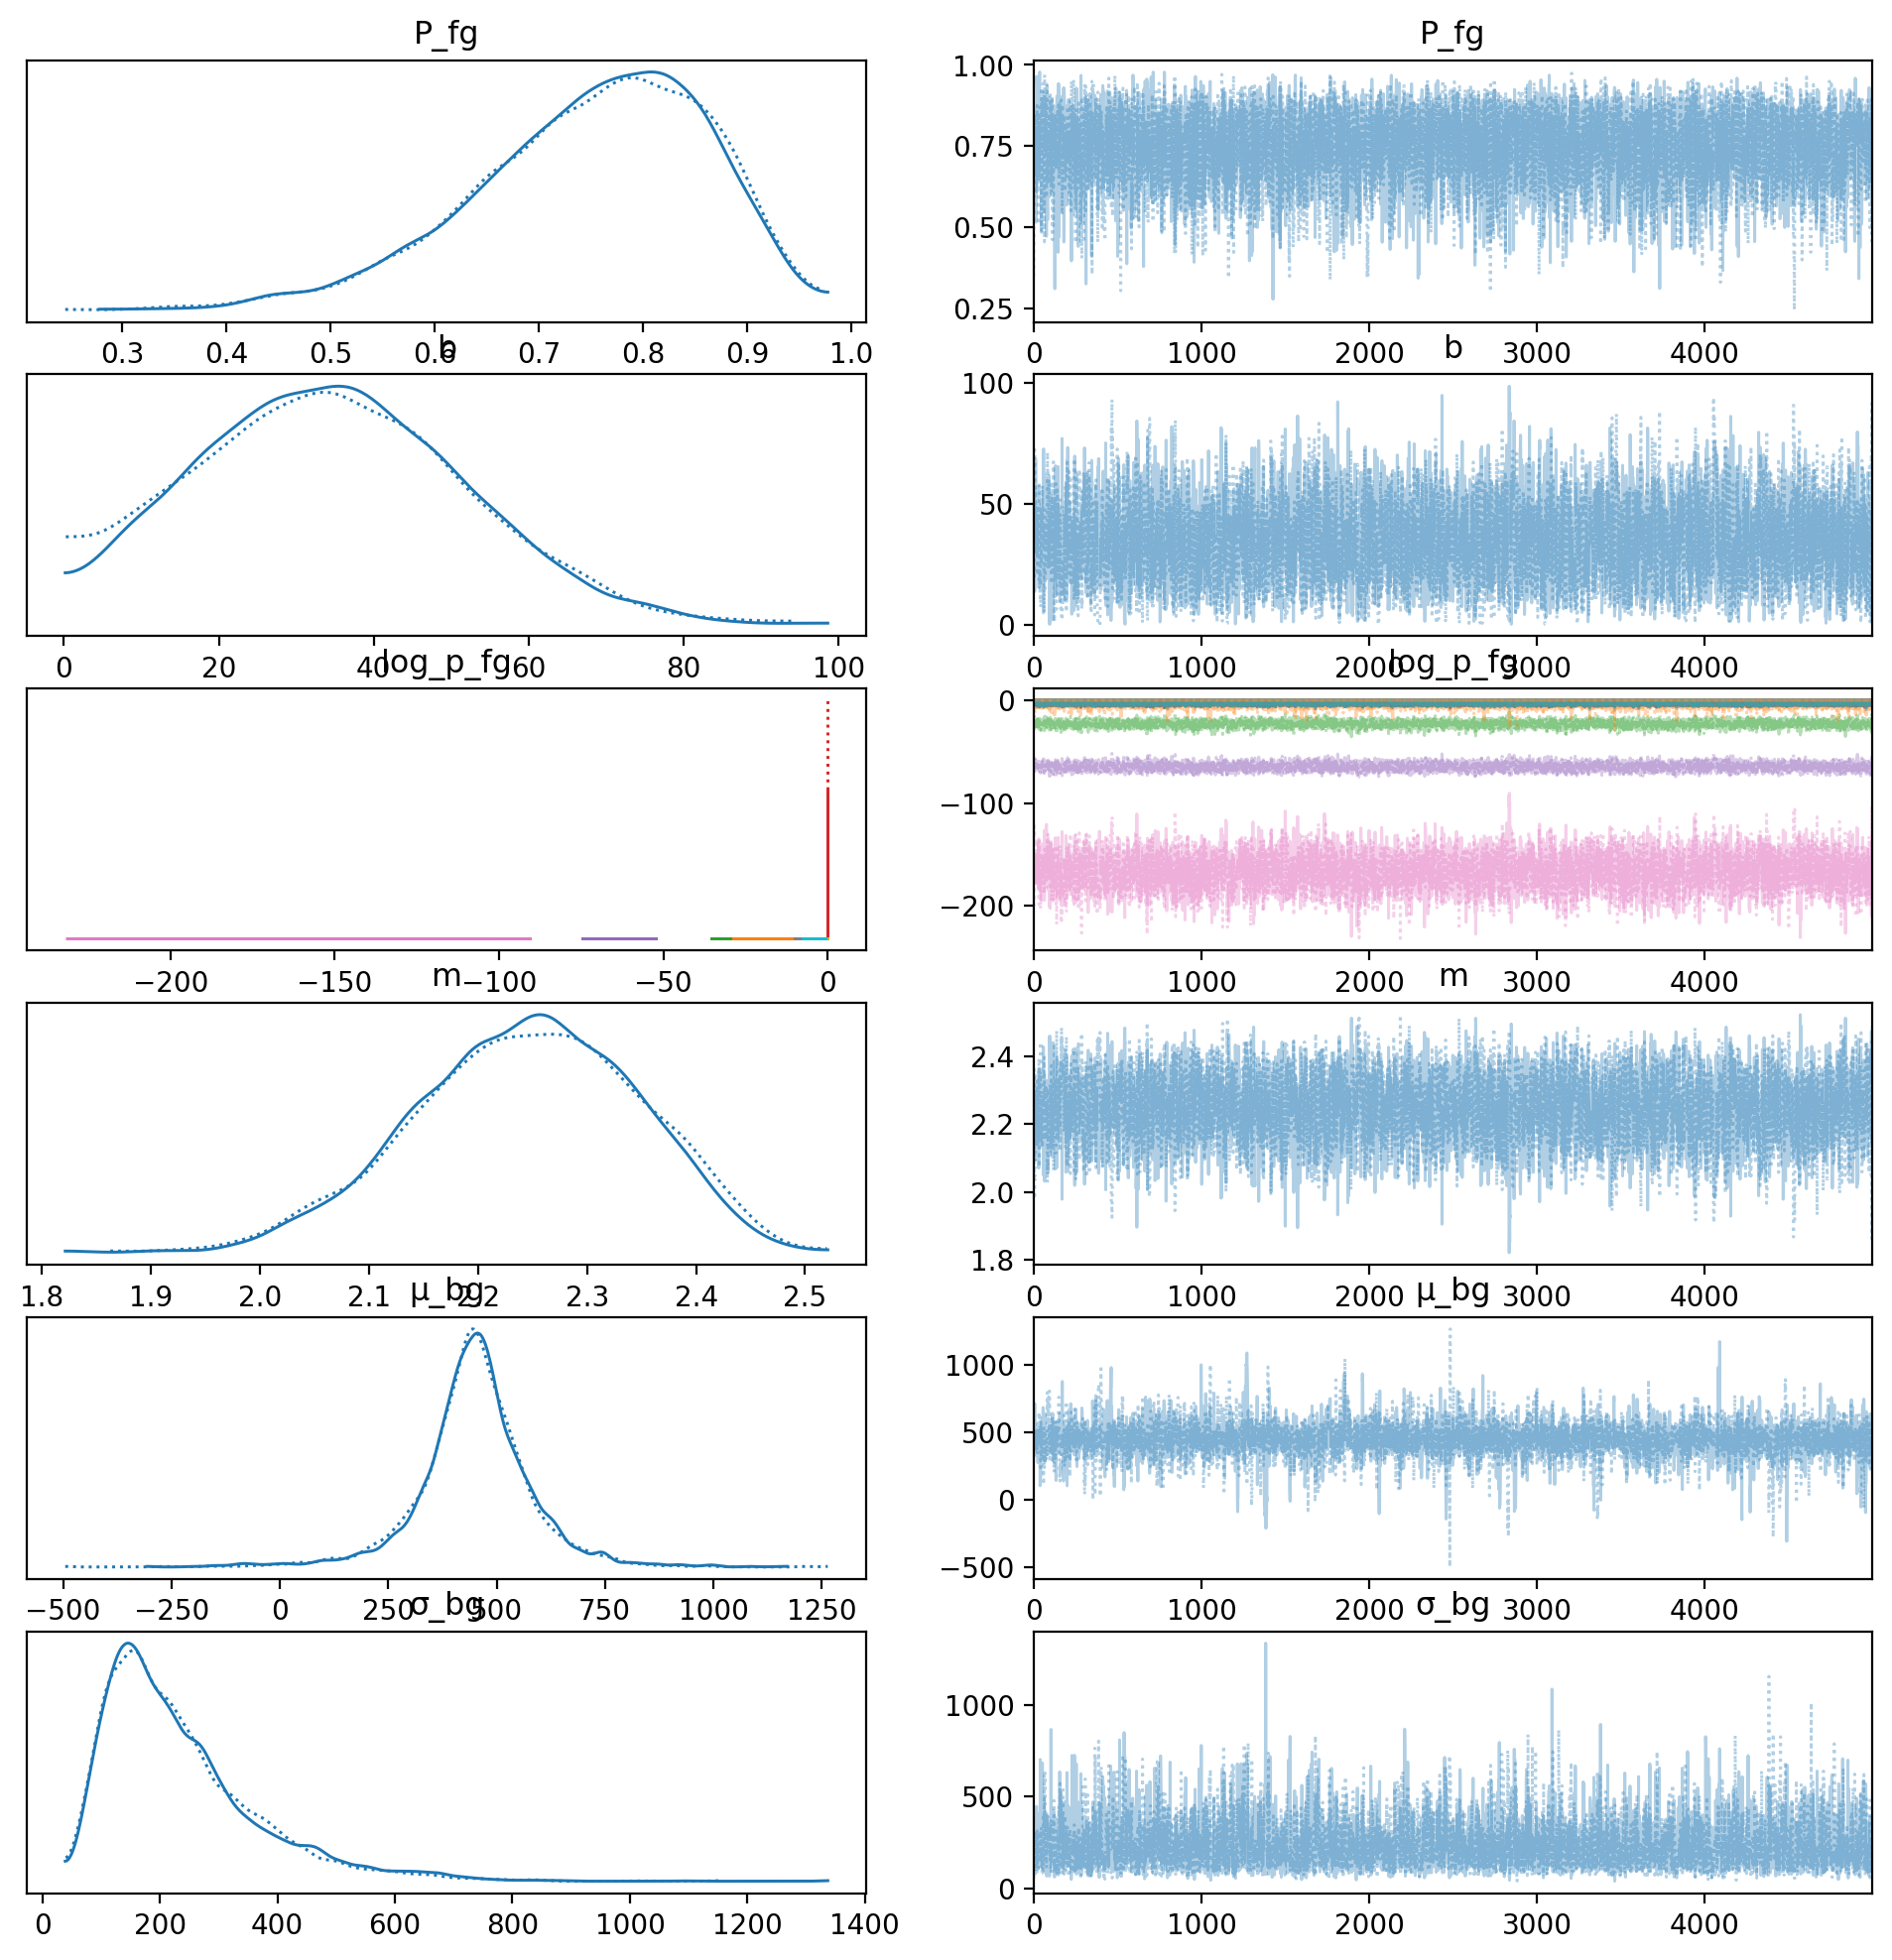

In [66]:
samples = mcmc.get_samples()
print(samples)
print(samples['b'].shape)
az.plot_trace(mcmc);

Still fuzzy caterpillars! And! Marginalized posterior appear to be a match! This is good - we would expect similar priors to not affect our posteriors greatly. If our posteriors depended too much on our initial conditions, which should be just a rough estimate of previous knowledge, we wouldn't be able to trust our conclusions very well.

In [67]:
samples = mcmc.get_samples()
samples

{'P_fg': Array([0.8623275 , 0.7022689 , 0.68505305, ..., 0.48615396, 0.7565801 ,
        0.897927  ], dtype=float32),
 'b': Array([21.584024, 46.229145, 53.160378, ..., 35.69183 , 56.80031 ,
        25.89259 ], dtype=float32),
 'log_p_fg': Array([[[-1.4778519e-01, -1.9849787e+00],
         [-2.4527256e+01,  0.0000000e+00],
         [-6.7129616e+01,  0.0000000e+00],
         ...,
         [-3.2806396e-02, -3.4334917e+00],
         [-1.5498638e-02, -4.1747484e+00],
         [-2.7413368e-02, -3.6104069e+00]],
 
        [[-1.7187405e-01, -1.8456988e+00],
         [-2.4786001e+01,  0.0000000e+00],
         [-6.1346069e+01,  0.0000000e+00],
         ...,
         [-7.9376698e-02, -2.5729785e+00],
         [-2.0835876e-02, -3.8814816e+00],
         [-1.1805010e-01, -2.1950908e+00]],
 
        [[-3.2037783e-01, -1.2941704e+00],
         [-2.2434418e+01,  0.0000000e+00],
         [-6.0706459e+01,  0.0000000e+00],
         ...,
         [-6.5755367e-02, -2.7545080e+00],
         [-3.5562515e-02,

In [69]:
def plot_data():
    plt.errorbar(data['x'], data['y'], yerr=data['sigm_y'], fmt=",k", ms=0, capsize=0, lw=1)
    plt.scatter(data['x'], data['y'], marker="o", s=5, c="k", label="data")
    plt.xlabel('x')
    plt.ylabel('y')

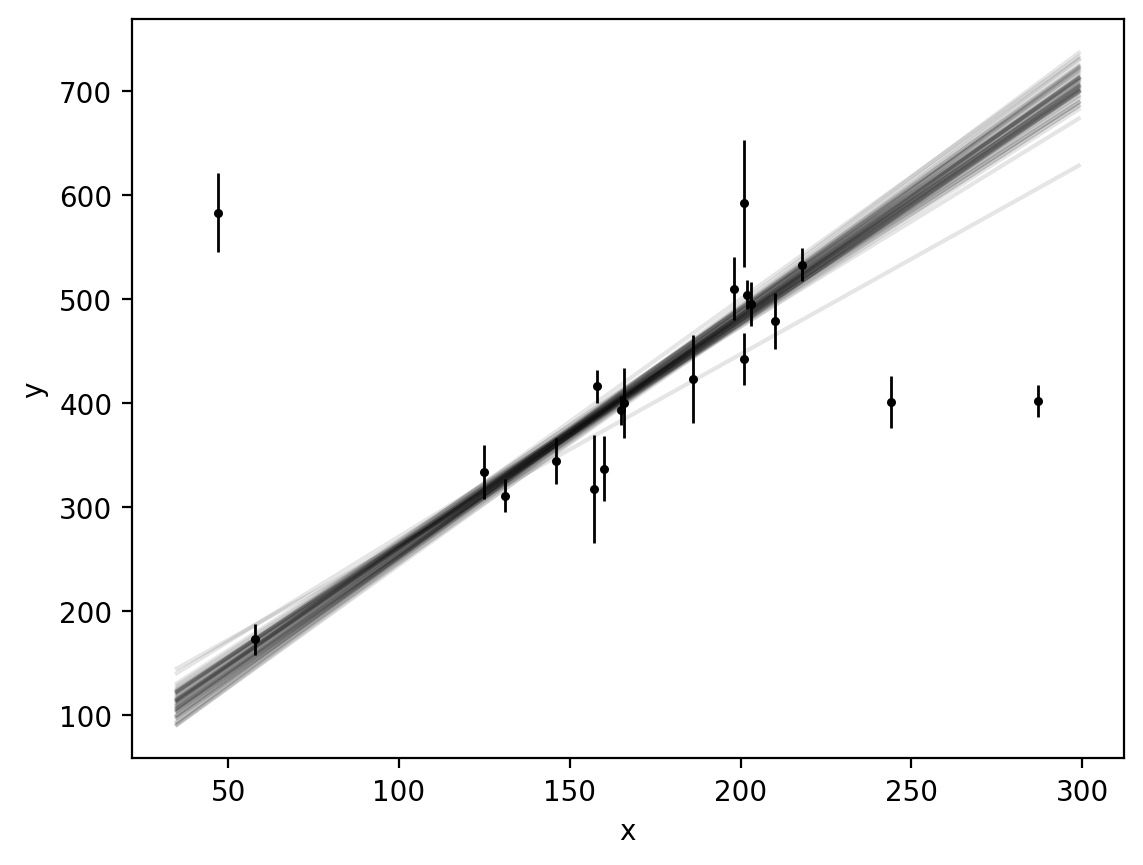

In [70]:
plot_data()

xlow, xhigh = plt.xlim()
x = jnp.linspace(xlow, xhigh, 100)

for i in random.choice(rng_key, num_samples, (50,)):
    mu = samples['m'][i] * x + samples['b'][i]
    plt.plot(x, mu, color='k', alpha=0.1);

To visually confirm our previous statement... yes! We get an equivalent best-fit line with outlier analysis even with slightly modified priors. Yay!

## 564 students
Repeat the Gaia linear regression analysis from the 564 portion of last week's homework, this time using `NumPyro`.

1. How do your results compare?
1. How about the efficiency of sampling?
1. Use the posterior predictive framework in `NumPyro` to simulate a new Gaia catalog from your model and posterior estimate.  How does it compare to the observed data?  How might we improve our model?

In [78]:
import pandas as pd
from numpyro import infer

In [83]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [ ]:
# Repeat initial steps from HW 4
df = pd.read_csv('../data/gaiadr3_solar_neighborhood.csv')
df

mg     bp_rp    parallax
0       10.390250  2.731872   10.000008
1        8.608481  2.025819   10.000029
2        4.267759  0.880858   10.000032
3       10.506658  2.649735   10.000066
4       12.077941  2.940875   10.000111
...           ...       ...         ...
227624  11.758283  2.834036  336.026602
227625   9.521769  2.215609  392.752945
227626  14.129570  4.184836  415.179416
227627  11.883816  2.833697  546.975940
227628  13.411743  3.804580  768.066539

[227629 rows x 3 columns]

In [74]:
nearby_sel = df.parallax > 40.
nearby_df = df[nearby_sel]
dwarf_sel = df.mg > 10 # white dwarfs are greater than 10 on y-axis
white_sel = df.bp_rp < 2 # and less than two on x-axis
dwarfless_df = df[~(white_sel & dwarf_sel) & nearby_sel] # remove these simultaneously, while continuing >40 parallax condition

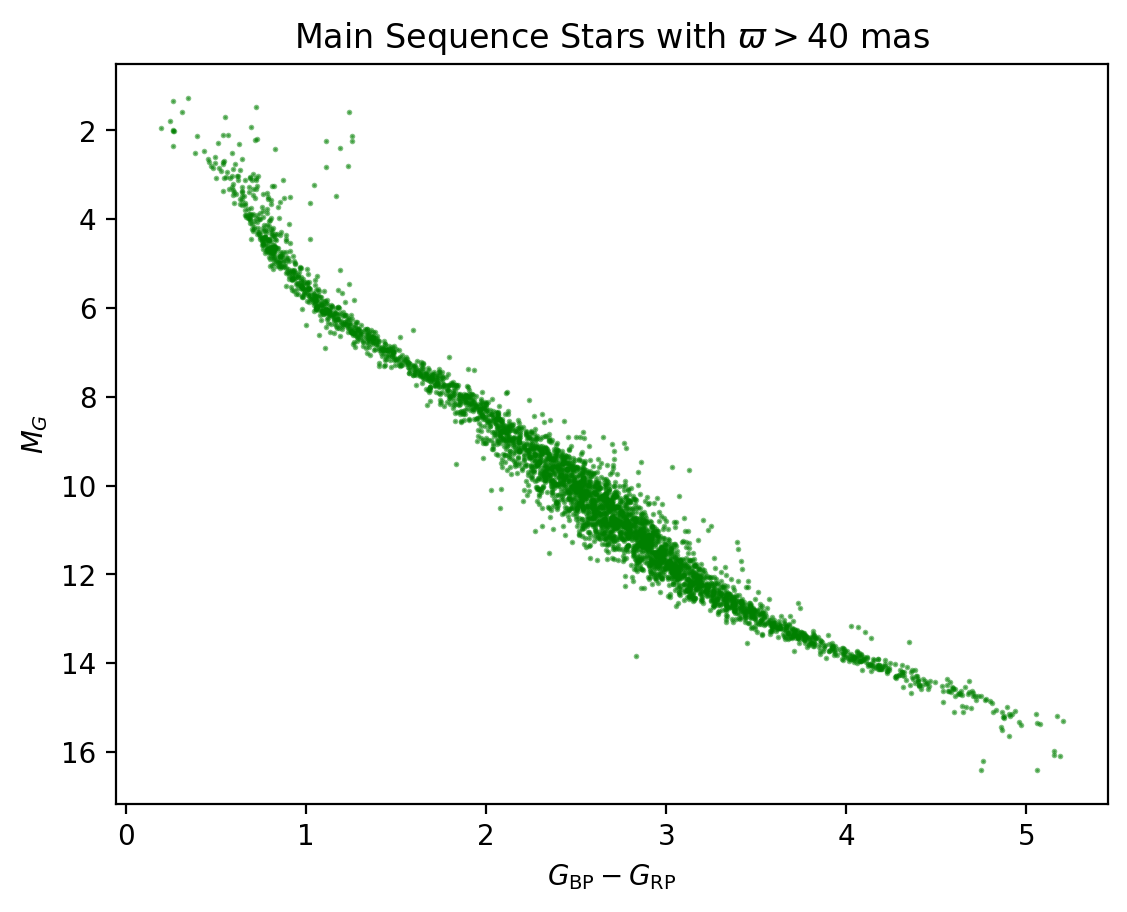

In [81]:
plt.scatter(dwarfless_df.bp_rp, dwarfless_df.mg, s=1, alpha=0.5, color='g')
plt.gca().invert_yaxis()
plt.title(r'Main Sequence Stars with $\varpi > 40$ mas')
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}$")
plt.ylabel(r"$M_G$")
plt.show()

In [94]:
def linear_model(x=None, y=None, σ_y=None):
    # priors
    m = numpyro.sample('m', dist.Uniform(0, 5))
    b = numpyro.sample('b', dist.Uniform(0, 50))
    σ_y=numpyro.sample('sigma',dist.Uniform(0,10))

    # define the mean of the normal distribution
    μ = m * x + b

    # Likelihood
    with numpyro.plate("data", len(x)):
        numpyro.sample("y", dist.Normal(μ, σ_y), obs=y)

In [97]:
type(dwarfless_df.bp_rp.values)

numpy.ndarray

In [103]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(linear_model)
num_samples = 1000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         x=dwarfless_df.bp_rp.values,
         y=dwarfless_df.mg.values)
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.58      0.03      2.58      2.54      2.63    691.39      1.00
         m      2.94      0.01      2.94      2.92      2.95    721.90      1.00
     sigma      0.56      0.01      0.56      0.55      0.57   1061.85      1.00

Number of divergences: 0


{'b': Array([2.5739238, 2.5489569, 2.612607 , ..., 2.5859494, 2.5936718,
       2.6095195], dtype=float32), 'm': Array([2.936038 , 2.9498048, 2.9279032, ..., 2.9336271, 2.9332018,
       2.925111 ], dtype=float32), 'sigma': Array([0.5753145 , 0.5555239 , 0.5711886 , ..., 0.5665311 , 0.56787777,
       0.5674384 ], dtype=float32)}


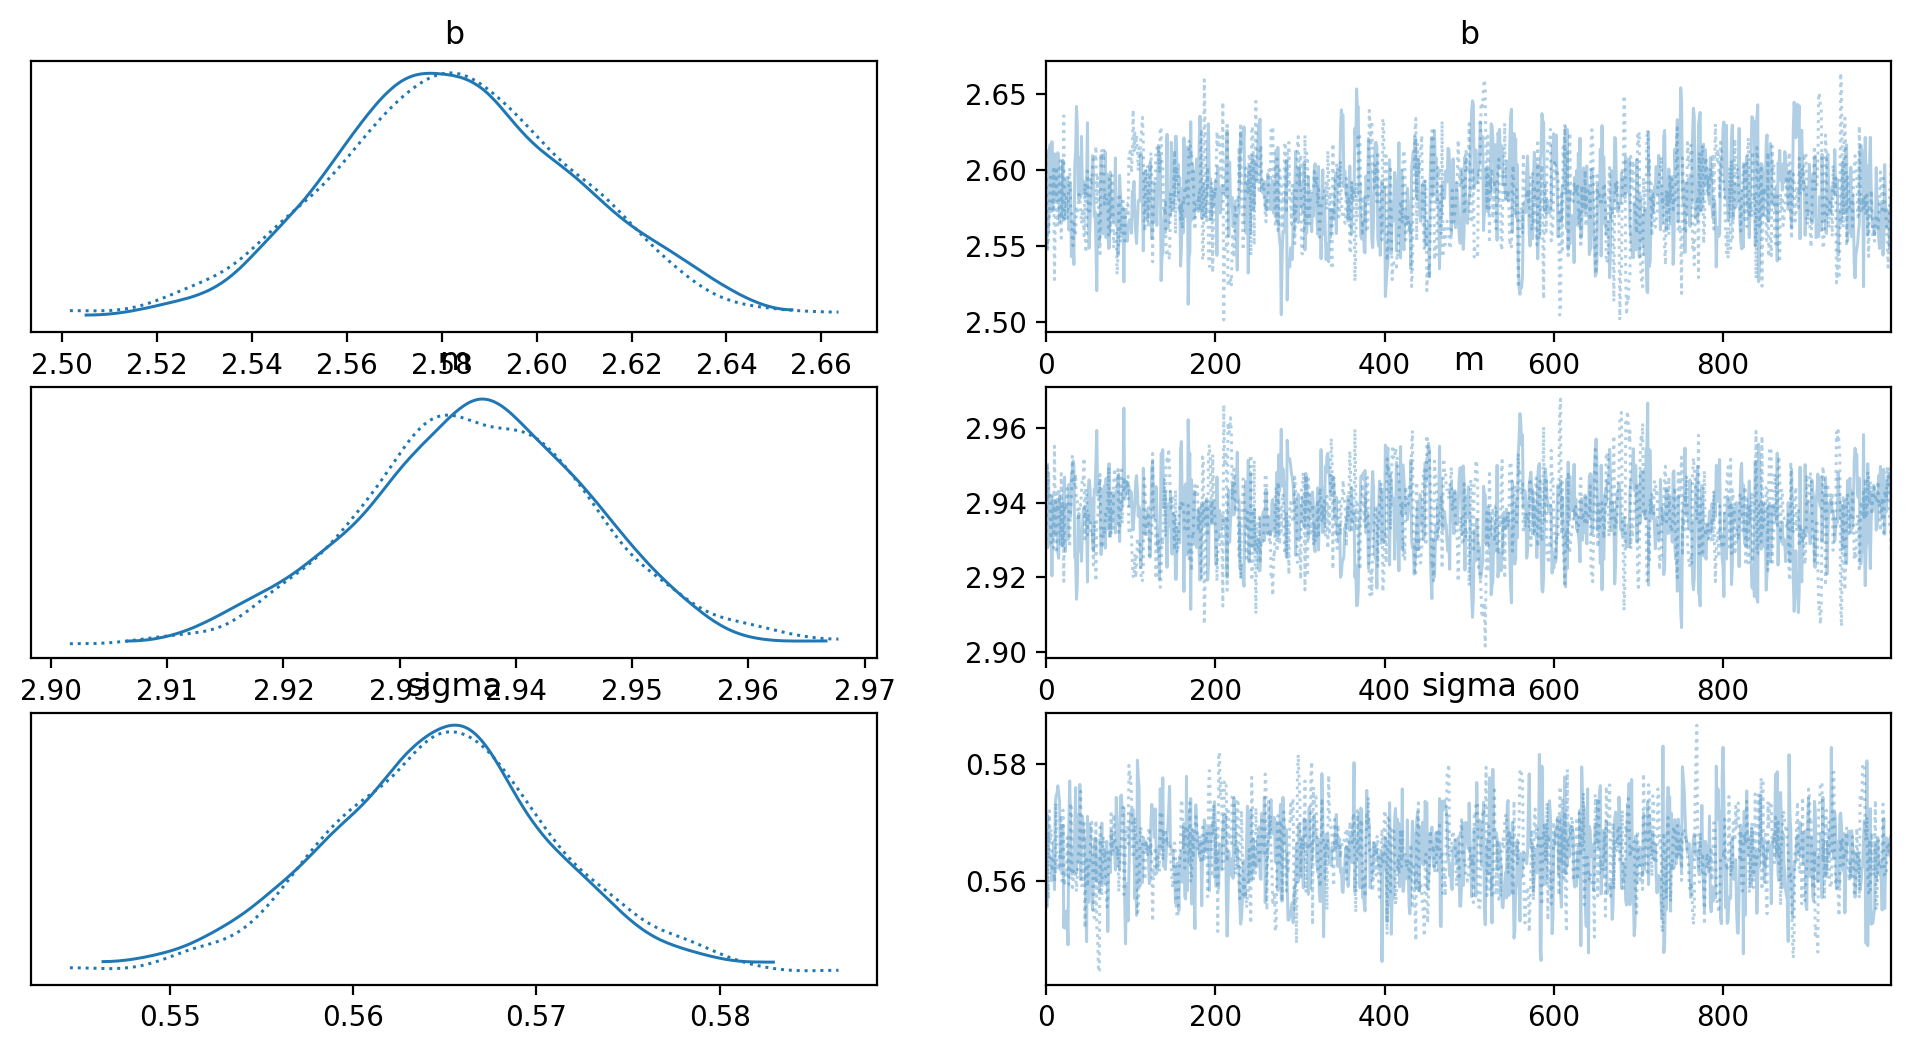

In [104]:
samples = mcmc.get_samples()
print(samples)
az.plot_trace(mcmc);

EUREKA! It works! And we're getting reasonable values for our intercept, slope and scatter!
### b = 2.58
### m = 2.94
### sigma = 0.565

In [122]:
def plot_data():
    plt.scatter(dwarfless_df.bp_rp.values, dwarfless_df.mg.values,alpha=0.5)
    plt.xlabel('bp_rp')
    plt.ylabel('mg')

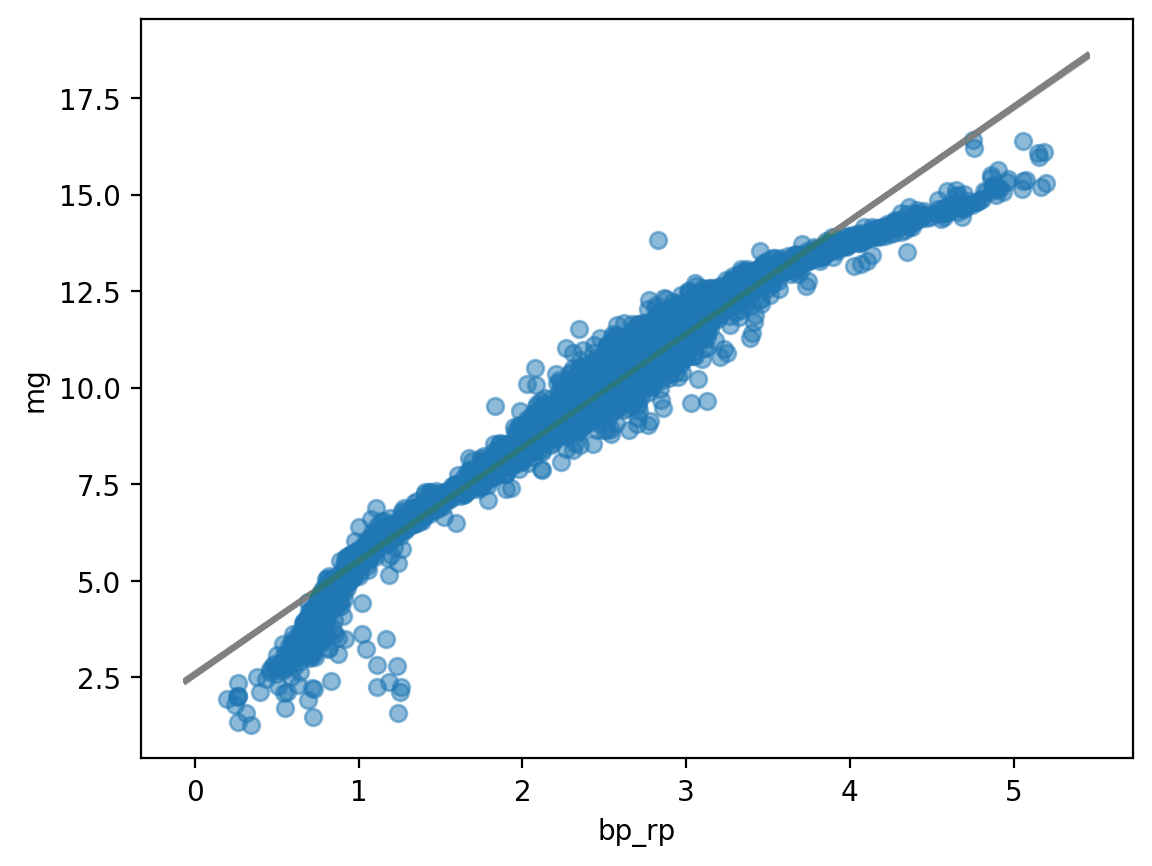

In [123]:
plot_data()

xlow, xhigh = plt.xlim()
x = jnp.linspace(xlow, xhigh, 100)


for i in random.choice(rng_key, num_samples, (500,)):
    mu = samples['m'][i] * x + samples['b'][i]
    plt.plot(x, mu, color='grey', alpha=0.01);

Sorry Jeff. Minimal scatter. Our 500 samples form just one chunky lad (best-fit-line)

1. How do the results compare?
Very similar! Attached is the trendline from last week with our hastings-metropolis sampler. 

Text(0, 0.5, '$M_G$')

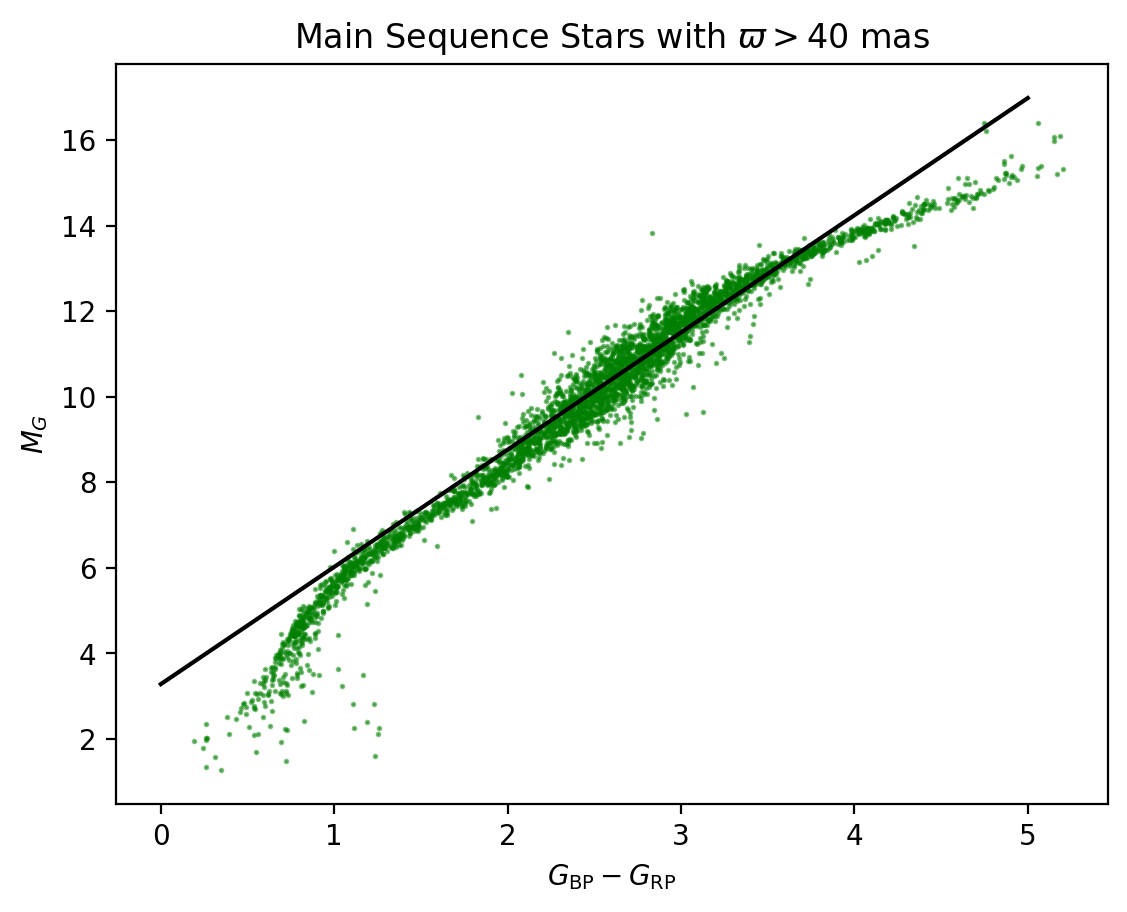

In [119]:
# Plot data and trendlines
plt.scatter(dwarfless_df.bp_rp, dwarfless_df.mg, s=1, alpha=0.5, color='g')
x=np.linspace(0,5,100)
b=3.28
m=2.74
def y(m,b):
    return m*x+b
plt.plot(x,y(m,b),color='black')
plt.title(r'Main Sequence Stars with $\varpi > 40$ mas')
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}$")
plt.ylabel(r"$M_G$")

Text(0, 0.5, '$M_G$')

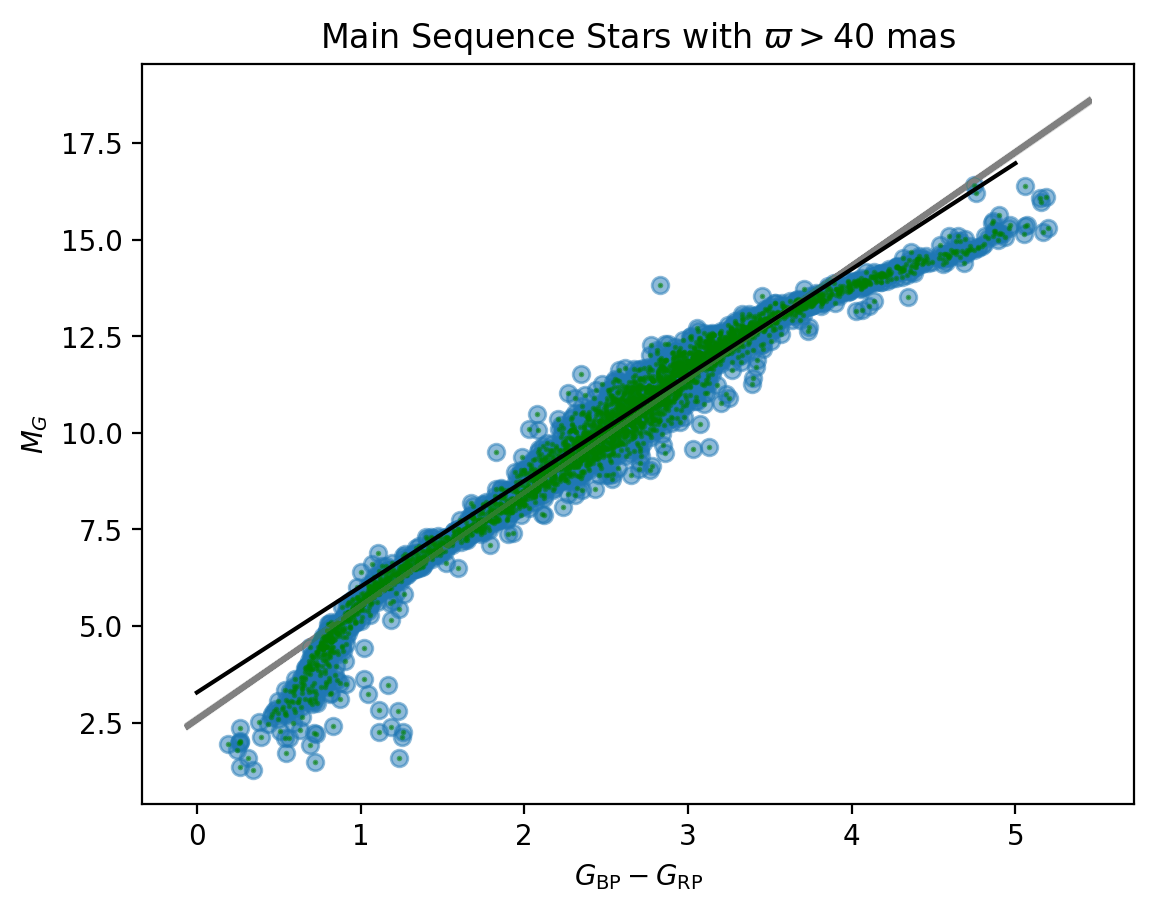

In [124]:
plot_data()

xlow, xhigh = plt.xlim()
x = jnp.linspace(xlow, xhigh, 100)


for i in random.choice(rng_key, num_samples, (500,)):
    mu = samples['m'][i] * x + samples['b'][i]
    plt.plot(x, mu, color='grey', alpha=0.01);
plt.scatter(dwarfless_df.bp_rp, dwarfless_df.mg, s=1, alpha=0.5, color='g')
x=np.linspace(0,5,100)
b=3.28
m=2.74
def y(m,b):
    return m*x+b
plt.plot(x,y(m,b),color='black')
plt.title(r'Main Sequence Stars with $\varpi > 40$ mas')
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}$")
plt.ylabel(r"$M_G$")

Plotting them on top gives the worst color scheme in the history of color schemes. Anyways. We can see that the best fit line from last week (black) is an almost perfect match with our current mcmc (grey). So, currently they should both be fine for modeling.

2. The jax/numpyro mcmc sampling only took ~11.5s, whereas my metropolis-hasting took 3-15 minutes! So, jax/numpyro 15 - 75 times faster! Would definitely prefer to use this in any project. It also was a far simpler method to use, since we called an mcmc method rather than hard coding our search. 

In [125]:
post_pred_samples = infer.Predictive(linear_model, samples)(
    random.PRNGKey(0), x=dwarfless_df.bp_rp.values, σ_y=dwarfless_df.mg
)
post_pred_y = post_pred_samples["y"]
post_pred_y.shape

(2000, 3820)

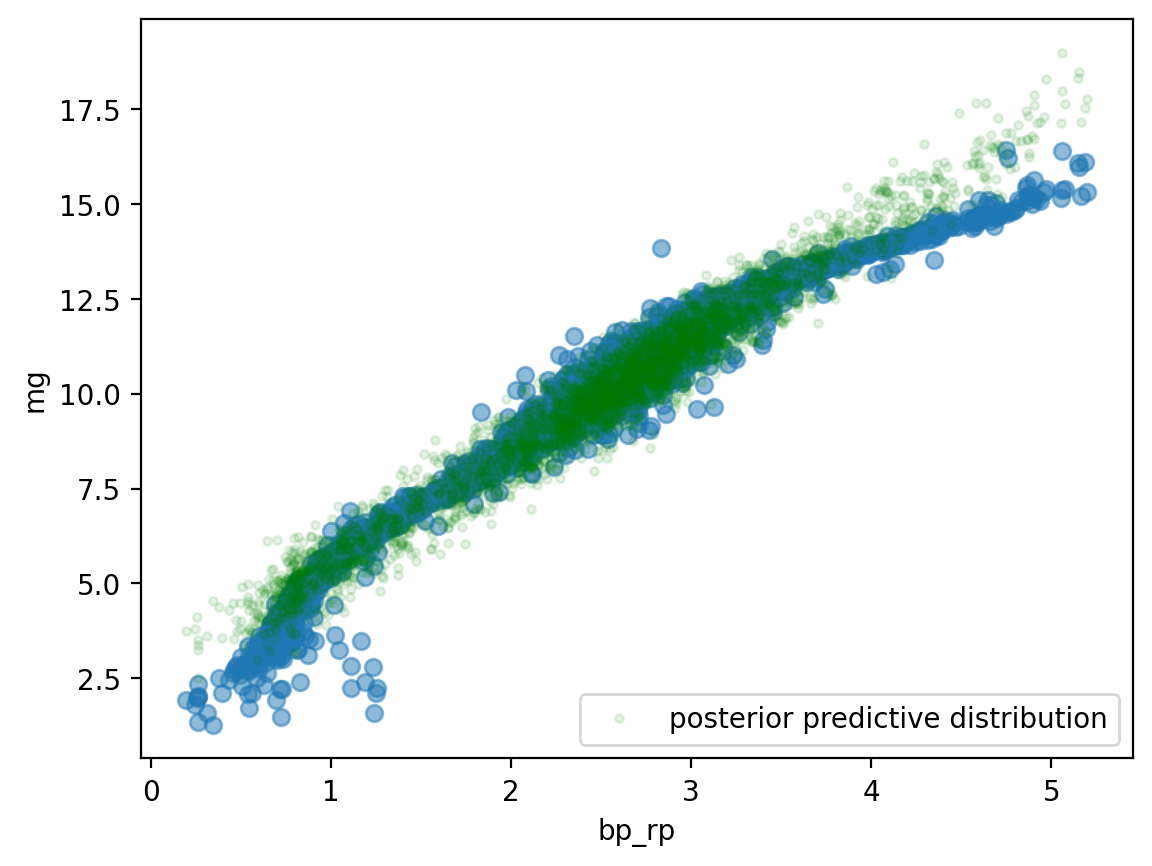

In [ ]:
plot_data()

label = "posterior predictive distribution"
for i in random.choice(rng_key, len(post_pred_y), (1,)):  # (1,) is the number of realizations
    plt.plot(dwarfless_df.bp_rp, post_pred_y[i], ".", color="g", alpha=0.1, label=label)
    label = 'Posterior Prediction'
plt.legend(loc="lower right");

Note that we need only one realization to cover almost all of our real data points. Hence, this seems to be a really good model. The data in the bottom left corner and top right is hard to cover, so perhaps we could do an outlier analysis to improve our model even further. However, these are likely physical phenomena rather than outliers due to noise, based on what we've been told about the data